# A1: Data Curation

This notebook will construct, analyze and publish a dataset of monthly traffic on English Wikipedia from January 1, 2008 through the end of last month. To change the ending month, `last_month` can be reassinged to the desired year and month (YYYYMM). Note that `last_month` used in both the API calls and generating file names.

In [1]:
import datetime

# Calculate last month; set to string
today = datetime.date.today()
last_month = (today.replace(day=1) - datetime.timedelta(days=1)).replace(day=1)
last_month = str(last_month.year) + str(last_month.strftime('%m'))
print(last_month)

202109


We will be using Wikipedia page traffic data from two different Wikimedia REST API endpoints, the Legacy Pagecounts API and the Pageviews API. In the API calls, you will want to specify the headers with your own information, as seen below:

In [2]:
# Customize these with your own information
headers = {
    'User-Agent': 'https://github.com/helen-ngo',
    'From': 'helenngo@uw.edu'
}

## Step 1: Data Acquisition

In [3]:
import json
import requests
import pandas as pd

While the Legacy Pagecounts API provides access to desktop and mobile traffic data from December 2007 through July 2016, the Pageviews API provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month. The endpoints and necessary parameters to get all aggregated data is already present in this notebook, but additinal information can be found in the links below:

Legacy Pagecounts API: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end

Pageviews API:
https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end



In [4]:
# The Legacy Pagecounts API
endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'

# The Pageviews API
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

We are interested in organic (user) traffic, so we will filter by `agent=user` when possible. Since only the Pageviews API has this feature, the Legacy Pagecounts data will include traffic by web crawlers or spiders. There is a set of parameters for each API and each API query type.

In [5]:
# Desktop access: parameters for getting aggregated legacy view data
params_legacy_desktop = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : last_month + "0100"
                    }

# Mobile access: parameters for getting aggregated desktop legacy view data
params_legacy_mobile = {"project" : "en.wikipedia.org",
                 "access-site" : "mobile-site",
                 "granularity" : "monthly",
                 "start" : "2007120100",
                # for end use 1st day of month following final month of data
                 "end" : last_month + "0100"
                    }

# Desktop access: parameters for getting aggregated current standard pageview data
params_pageviews_desktop = {"project" : "en.wikipedia.org",
                    "access" : "desktop",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : last_month + "0100"
                        }

# Mobile website access: parameters for getting aggregated current standard pageview data
params_pageviews_mobile_web = {"project" : "en.wikipedia.org",
                    "access" : "mobile-web",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : last_month + "0100"
                        }

# Mobile app access: parameters for getting aggregated current standard pageview data
params_pageviews_mobile_app = {"project" : "en.wikipedia.org",
                    "access" : "mobile-app",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2007120100",
                    # for end use 1st day of month following final month of data
                    "end" : last_month + "0100"
                        }

Since every JSON-formatted source data file must contain the complete and unedited output of the API queries, we will use a function, `save_api_call`, that calls the API and saves the response. In addition, `save_api_call` will also format the JSON object into a pandas dataframe, setting us up for the next step, data processing.

In [6]:
def save_api_call(endpoint,parameters,filename):
    """
    save_api_call saves the unedited JSON-formatted ouput of a Legacy Pagecounts API or Pageviews API call, 
    then it reformats the output into a pandas dataframe.

    endpoint: Legacy Pagecounts API or Pageviews API endpoint
    parameters: parameters for respective API
    filename: name of the JSON file to be saved
    return: pandas dataframe of the response from API call
    """ 
    
    # Make API call
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    # Save JSON output
    with open(filename, "w") as outfile:
        json.dump(response, outfile)
    
    # Convert output to pandas dataframe
    json_flat = pd.json_normalize(response, record_path =['items'])

    return json_flat

In [7]:
# API query for legacy desktop traffic data
monthly_legacy_desktop = save_api_call(endpoint_legacy, params_legacy_desktop,"pagecounts_desktop-site_200712-" + last_month + ".json")

# API query for legacy mobile traffic data
monthly_legacy_mobile = save_api_call(endpoint_legacy, params_legacy_mobile,"pagecounts_mobile-site_200712-" + last_month + ".json")

# API query for current pageviews desktop traffic data
monthly_pageviews_desktop = save_api_call(endpoint_pageviews, params_pageviews_desktop,"pageviews_desktop_200712-" + last_month + ".json")

# API query for current pageviews mobile website traffic data
monthly_pageviews_mobile_web = save_api_call(endpoint_pageviews, params_pageviews_mobile_web,"pageviews_mobile-web_200712-" + last_month + ".json")

# API query for current pageviews mobile app traffic data
monthly_pageviews_mobile_app = save_api_call(endpoint_pageviews, params_pageviews_mobile_app,"pageviews_mobile-app_200712-" + last_month + ".json")


## Step 2: Data processing

For all data, we will separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM). The day and hour (DDHH) values will be discarded when the dataframes are combined.

In [8]:
def separate_timestamp(monthly_traffic_df):
    monthly_traffic_df["year"] = monthly_traffic_df["timestamp"].str.extract('(^\d{4})')
    monthly_traffic_df["month"] = monthly_traffic_df["timestamp"].str.extract('((?<=\d{4})\d{2})')
        
    return monthly_traffic_df

In [9]:
# Separate timestamps for each API/access type
monthly_legacy_desktop = separate_timestamp(monthly_legacy_desktop)
monthly_legacy_mobile = separate_timestamp(monthly_legacy_mobile)
monthly_pageviews_desktop = separate_timestamp(monthly_pageviews_desktop)
monthly_pageviews_mobile_web = separate_timestamp(monthly_pageviews_mobile_web)
monthly_pageviews_mobile_app = separate_timestamp(monthly_pageviews_mobile_app)

For data collected from the Pageviews API, we will combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month. 

In [10]:
monthly_pageviews_mobile = pd.concat([monthly_pageviews_mobile_web,monthly_pageviews_mobile_app])
monthly_pageviews_mobile = monthly_pageviews_mobile.groupby(['year','month']).sum('views').reset_index()
monthly_pageviews_mobile

,year,month,views
0,2015,07,3288755294
1,2015,08,3302333038
2,2015,09,3170203333
3,2015,10,3268499132
4,2015,11,3236601070
...,...,...,...
69,2021,04,4759095083
70,2021,05,4976579558
71,2021,06,4584510417
72,2021,07,4778909421


Before we combine all data into a single CSV file, we will add a column to each set of data that identifies the API and access method. Note that the day and hour values will be discarded when combining all the data into one dataframe.

In [11]:
# Create column for api type
monthly_legacy_desktop["api_access"] = 'pagecount_desktop_views'
monthly_legacy_mobile["api_access"] = 'pagecount_mobile_views'
monthly_pageviews_desktop["api_access"] = 'pageview_desktop_views'
monthly_pageviews_mobile["api_access"] = 'pageview_mobile_views'

In [12]:
# Combine together to one dataframe
monthly_legacy_desktop.rename(columns={"count": "views"},inplace = True)
monthly_legacy_mobile.rename(columns={"count": "views"},inplace = True)
monthly_views = pd.concat([monthly_legacy_desktop,monthly_legacy_mobile, monthly_pageviews_desktop, monthly_pageviews_mobile])

In [13]:
# Pivot data frame by year and month for each api/views
monthly_views = monthly_views.pivot_table(
    index=['year', 'month'],
    columns='api_access',
    values='views',
    fill_value=0)
monthly_views.index.name = monthly_views.columns.name = None

Once we combine all the data into `monthly_views`, we can calculate the total views per month for English Wikipedia. Finally, we will save the data as a CSV.

In [14]:
# Calculate total views for each api by year and month
monthly_views['pagecount_all_views'] = monthly_views['pagecount_desktop_views'] + monthly_views['pagecount_mobile_views']
monthly_views['pageview_all_views'] = monthly_views['pageview_desktop_views'] + monthly_views['pageview_mobile_views']
monthly_views = monthly_views[['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
                               'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]
monthly_views


pagecount_all_views  pagecount_desktop_views  \
year month                                                 
2007 12              2998331524               2998331524   
2008 01              4930902570               4930902570   
     02              4818393763               4818393763   
     03              4955405809               4955405809   
     04              5159162183               5159162183   
...                         ...                      ...   
2021 04                       0                        0   
     05                       0                        0   
     06                       0                        0   
     07                       0                        0   
     08                       0                        0   

            pagecount_mobile_views  pageview_all_views  \
year month                                               
2007 12                          0                   0   
2008 01                          0                   0   
     02                          0                   0   
     03                          0                   0   
     04                          0                   0   
...                            ...                 ...   
2021 04                          0          7641809575   
     05                          0          7800995735   
     06                          0          7090481783   
     07                          0          7544493789   
     08                          0          7495607934   

            pageview_desktop_views  pageview_mobile_views  
year month                                                 
2007 12                          0                      0  
2008 01                          0                      0  
     02                          0                      0  
     03                          0                      0  
     04                          0                      0  
...                            ...                    ...  
2021 04                 2882714492             4759095083  
     05                 2824416177             4976579558  
     06                 2505971366             4584510417  
     07                 2765584368             4778909421  
     08                 2763413934             4732194000  

[165 rows x 6 columns]

In [15]:
monthly_views.to_csv('en-wikipedia_traffic_200712-' + last_month + '.csv')

## Step 3: Analysis

In our final step, we will visualize the dataset we created as a time series graph. Due to the nature of a time series, we will acknowledge unknown or missing data as `NaN` and convert the `year` and `month` variables into a `datetime` index.

In [16]:
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# Replace all 0 with NA before graphing
cols = ['pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views',
        'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']
monthly_views[cols] = monthly_views[cols].replace({0:np.nan, 0:np.nan, 0:np.nan, 0:np.nan, 0:np.nan, 0:np.nan})

In [18]:
# Set index as datetime for time series
monthly_views = monthly_views.reset_index()
monthly_views = monthly_views.set_index(pd.to_datetime(monthly_views[['year','month']].assign(day=1)))

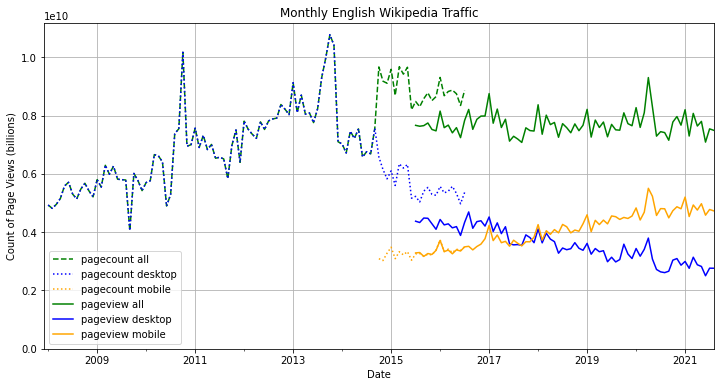

In [19]:
# Create figure and plot space
fig, ax = plt.subplots(figsize=(12, 6))

# Plot all view counters
monthly_views.pagecount_all_views["2008-01-01":"2016-07-01"].plot(grid=True, label="pagecount all", linestyle='dashed', color='green')
monthly_views.pagecount_desktop_views["2008-01-01":"2016-07-01"].plot(grid=True, label="pagecount desktop", linestyle='dotted', color='blue')
monthly_views.pagecount_mobile_views["2008-01-01":"2016-07-01"].plot(grid=True, label="pagecount mobile", linestyle='dotted', color='orange')
monthly_views.pageview_all_views.plot(grid=True, label="pageview all", color='green')
monthly_views.pageview_desktop_views.plot(grid=True, label="pageview desktop", color='blue')
monthly_views.pageview_mobile_views.plot(grid=True, label="pageview mobile", color='orange')

# Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Count of Page Views (billions)",
       title="Monthly English Wikipedia Traffic")

# Add legend
ax.legend()

# Set lower y-axis limit
plt.gca().set_ylim(bottom=0)

# Generate a .png formatted image of final graph.
plt.savefig('en-wikipedia_traffic_200712-' + last_month + '.png')

Solid lines mark data the from the current API. Notice how the data does not reconcile in the overlapping year, where we have data from both Legacy Pagecount and Pageview. This is most likely attributed to the inclusion of inorganic traffic in Legacy Pagecount, but not Pageview.